# MESQUAL 103: Scenario Attributes

## Setup

First, we need to set up the environment. If you are on Colab, the first cell will clone and install all dependencies. You will have to restart the session afterwards and continue with cell 2. If you are in a local environment, make sure that you have followed the Getting started steps in the README, so that mesqual and all requirements are installed.

In [1]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import importlib.util

    def is_module_available(module_name):
        return importlib.util.find_spec(module_name) is not None

    if os.path.exists("mesqual-vanilla-studies") and is_module_available("mesqual"):
        print("✅ Environment already set up. Skipping installation.")
    else:
        print("🔧 Setting up Colab environment...")
        !git clone --recursive https://github.com/helgeesch/mesqual-vanilla-studies.git
        %cd mesqual-vanilla-studies/

        !pip install git+https://github.com/helgeesch/mesqual -U
        !pip install git+https://github.com/helgeesch/mesqual-pypsa -U
        !pip install git+https://github.com/helgeesch/captain-arro -U
        !pip install -r requirements.txt

        print('✅ Setup complete. 🔁 Restart the session, then skip this cell and continue with the next one.')
else:
    print("🖥️ Running locally. No setup needed.")

Running locally, let's continue.


In [2]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import sys
    sys.path.append('/content/mesqual-vanilla-studies')
    os.chdir('/content/mesqual-vanilla-studies')
else:
    def setup_notebook_env():
        """Set working directory to repo root and ensure it's in sys.path."""
        import os
        import sys
        from pathlib import Path

        def find_repo_root(start_path: Path) -> Path:
            current = start_path.resolve()
            while current != current.parent:
                if (current / 'vanilla').exists():
                    return current
                current = current.parent
            raise FileNotFoundError(f"Repository root not found from: {start_path}")

        repo_root = find_repo_root(Path.cwd())
        os.chdir(repo_root)
        if str(repo_root) not in sys.path:
            sys.path.insert(0, str(repo_root))

    setup_notebook_env()

try:
    from mesqual import StudyManager
except ImportError:
    raise ImportError("❌ 'mesqual' not found. If you're running locally, make sure you've installed all dependencies as described in the README.")

if not os.path.isdir("studies"):
    raise RuntimeError(f"❌ 'studies' folder not found. Make sure your working directory is set to the mesqual-vanilla-studies root. Current working directory: {os.getcwd()}")

print("✅ Environment ready. Let’s go!")

✅ Environment ready. Let’s go!


In [3]:
import os
import plotly.express as px
import pypsa

from mesqual import StudyManager
from mesqual.utils.pandas_utils import flatten_df, prepend_model_prop_levels, filter_by_model_query
from mesqual.utils.plotly_utils.plotly_theme import PlotlyTheme
from mesqual_pypsa import PyPSADataset
from vanilla.notebook_config import configure_clean_output_for_jupyter_notebook
from vanilla.conditional_renderer import ConditionalRenderer

configure_clean_output_for_jupyter_notebook()
PlotlyTheme().apply()
renderer = ConditionalRenderer()

In [4]:
# Register study-specific interpreters (details on this will be covered in a later notebook)
from studies.study_01_intro_to_mesqual.src.study_specific_model_interpreters import ControlAreaModelInterpreter, ScigridDEBusModelInterpreter

PyPSADataset.register_interpreter(ControlAreaModelInterpreter)
PyPSADataset.register_interpreter(ScigridDEBusModelInterpreter)

# setup up study same as in previous notebooks, but this time also set attributes
study_folder = 'studies/study_01_intro_to_mesqual'
networks_folder = os.path.join(study_folder, 'data/networks_scigrid_de')

n_base = pypsa.Network(os.path.join(networks_folder, 'base.nc'))
n_solar_150 = pypsa.Network(os.path.join(networks_folder, 'solar_150.nc'))
n_solar_200 = pypsa.Network(os.path.join(networks_folder, 'solar_200.nc'))
n_wind_150 = pypsa.Network(os.path.join(networks_folder, 'wind_150.nc'))
n_wind_200 = pypsa.Network(os.path.join(networks_folder, 'wind_200.nc'))

study = StudyManager.factory_from_scenarios(
    scenarios=[
        PyPSADataset(n_base,        name='base'),
        PyPSADataset(n_solar_150,   name='solar_150', attributes=dict(res_tech='solar', scaling_factor=150)),
        PyPSADataset(n_solar_200,   name='solar_200', attributes=dict(res_tech='solar', scaling_factor=200)),
        PyPSADataset(n_wind_150,    name='wind_150', attributes=dict(res_tech='wind', scaling_factor=150)),
        PyPSADataset(n_wind_200,    name='wind_200', attributes=dict(res_tech='wind', scaling_factor=200)),
    ],
    comparisons=[('solar_150', 'base'), ('solar_200', 'base'), ('wind_150', 'base'), ('wind_200', 'base')],
    export_folder=os.path.join(study_folder, 'non_versioned/output'),
)

In [5]:
scen_attributes_df = study.scen.get_attributes_concat_df()
print(scen_attributes_df)

attribute res_tech scaling_factor
dataset                          
base           NaN            NaN
solar_150    solar            150
solar_200    solar            200
wind_150      wind            150
wind_200      wind            200


Of course, the same method can be called for the collection of comparisons and returns a similar df. 

In [6]:
comp_attributes_df = study.comp.get_attributes_concat_df()
print(comp_attributes_df)

attribute         res_tech scaling_factor variation_dataset reference_dataset
dataset                                                                      
solar_150 vs base    solar            150         solar_150              base
solar_200 vs base    solar            200         solar_200              base
wind_150 vs base      wind            150          wind_150              base
wind_200 vs base      wind            200          wind_200              base


As you can see, for DatasetComparisons, the method automatically uses the attributes of the variation dataset while also including the names to variation as well as reference dataset. You could, of course, also set attributes explicitly for every comparison dataset individually.

From the previous notebooks, you might also remember that there is even a combined dataset for all scenarios + comparisons. The method even works for this one, as you can see below.

In [7]:
print(study.scen_comp.get_attributes_concat_df())

attribute                    res_tech scaling_factor variation_dataset reference_dataset
type       dataset                                                                      
scenario   base                   NaN            NaN               NaN               NaN
           solar_150            solar            150               NaN               NaN
           solar_200            solar            200               NaN               NaN
           wind_150              wind            150               NaN               NaN
           wind_200              wind            200               NaN               NaN
comparison solar_150 vs base    solar            150         solar_150              base
           solar_200 vs base    solar            200         solar_200              base
           wind_150 vs base      wind            150          wind_150              base
           wind_200 vs base      wind            200          wind_200              base


You might be wondering, when would we need these attributes? Making use of Dataset attributes is entirely optional, but is extremely useful, for example when you want to categorize or group your assessment by different attributes.

In the example below, we want to show the average price change per control area and categorize the scenarios by res_tech and scaling_factor, here we go:

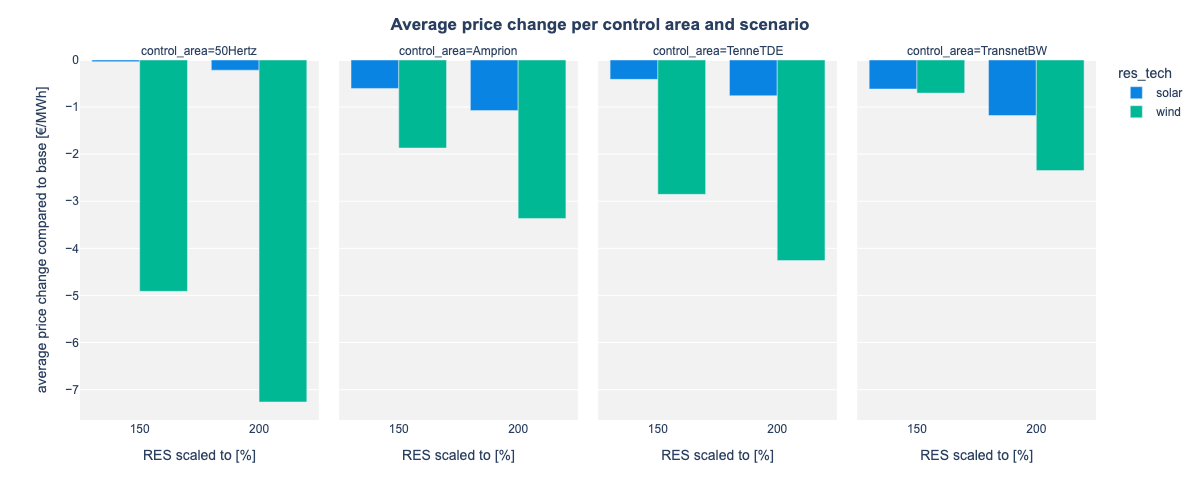

In [8]:
comp_attributes_df = study.comp.get_attributes_concat_df()
buses_model_df = study.scen.get_dataset('base').fetch('buses')
data = study.comp.fetch('buses_t.marginal_price')
data = prepend_model_prop_levels(data, buses_model_df, 'control_area')
data = data.T.groupby(level=['dataset', 'control_area']).mean().T
data = data.mean().to_frame('value')
data = prepend_model_prop_levels(data, comp_attributes_df, 'res_tech', 'scaling_factor')
data = data.reset_index()
fig = px.bar(
    data_frame=data,
    x='scaling_factor',
    y='value',
    color='res_tech',
    facet_col='control_area',
    labels={'scaling_factor': 'RES scaled to [%]', 'value': 'average price change compared to base [€/MWh]'},
    barmode='group',
)
fig.update_layout(title='<b>Average price change per control area and scenario</b>', width=1200)

renderer.show_plotly(fig)

You might have spottet that the prepend_model_prop_levels method is applied in combination with the comp_attributes_df. In this application, the attributes_df basically just functions as a model_df (mapping from object names to properties/memberships/attributes) for the index level with dataset names.

In many cases, dataset attributes are actually retrievable from the raw-data folder / file and can be interpreted based on a rule. This is especially useful if you are managing more than just a hand full of scenarios with potentially many attribute dimensions.

The used method in the example below utilizes the rule based attribute setting and sets up the study manager instance by a method call. Visit the source code if you want to see the implementation for yourself. 

In [9]:
from studies.study_01_intro_to_mesqual.scripts.setup_study_manager import get_scigrid_de_study_manager

study = get_scigrid_de_study_manager()  # same study setup as from above, using rule based attribute attribution and a re-usable script.

## Key Takeaways

- **Dataset Attribute Feature**: Describe scenarios and scenario comparisons with attributes and have the information at hand during your assessment.
- **Modularity of descriptive `model_df` framework**: Treat the attributes_df as if it was a `model_df` for the dataset names and make use of tools like `filter_by_model_query` and `prepend_model_prop_levels` in combination with multi-scenario (multi-scenario-comparison) dataframes.